In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import tslearn
import os
import tslearn.utils 
import seaborn
import pylab
from tslearn.clustering import TimeSeriesKMeans, KShape
import matplotlib.ticker as ticker
import zipfile

In [24]:
points_path = "./iHUB - CoM - Library at the Dock/CSV_Lib@Dock/eletrical meter/"
raw_data = []
for zip_filename in os.listdir(points_path):
    zip_path = os.path.join(points_path, zip_filename)
    zip_obj = zipfile.ZipFile(zip_path)
    csv_file = zip_obj.open('E.R. Energy Usage Hour kWh.csv')
    # remove first line
    csv_file.readline()
    
    raw_data.append(pd.read_csv(csv_file))

In [56]:
def preprocessing(meter):
    t = list(meter.columns)
    t[0] = "Time stamp"
    meter.columns = t
    meter_preprocessed = meter[["Time stamp", "Value"]].dropna(axis=0, how='any')
    # meter_preprocessed["Value"] = meter_preprocessed["Value"].apply(lambda s: float(s.replace(",", "")))
    meter_preprocessed["Time stamp"] = pd.to_datetime(meter_preprocessed["Time stamp"], format="%d/%m/%Y %I:%M:%S %p %Z")
    meter_preprocessed = meter_preprocessed[meter_preprocessed["Value"] < 1000]
  
    meter_preprocessed = meter_preprocessed[["Time stamp", "Value"]].dropna(axis=0, how='any')
    beg= meter_preprocessed["Time stamp"].min().replace(hour=0, minute=59, second=57)
    end = meter_preprocessed["Time stamp"].max().replace(hour=23, minute=59, second=57)
    helper = pd.DataFrame({"Time stamp": pd.date_range(beg, end, freq='1H')})
    meter_preprocessed = pd.merge(meter_preprocessed, helper, on='Time stamp', how='outer').sort_values('Time stamp')    
    meter_preprocessed = pd.merge(meter_preprocessed, helper, on='Time stamp', how='inner').sort_values('Time stamp')

    meter_preprocessed['Value'] = meter_preprocessed['Value'].interpolate(method='linear')
    meter_preprocessed = meter_preprocessed[meter_preprocessed["Time stamp"] > beg] 
    meter_preprocessed = meter_preprocessed[(meter_preprocessed["Time stamp"] < end)] 
    meter_preprocessed = meter_preprocessed.drop_duplicates(subset=["Time stamp"])
    return meter_preprocessed

In [57]:
preprocessed_data = [preprocessing(x) for x in raw_data]

In [58]:
for x in preprocessed_data: 
    print(len(x))

8782
8782
8782
8782
8782
8782
8782
8782
8782
8782
8782
8782
8782
8782
8782
8782
8782
8782
8782
8782


In [83]:
print(preprocessed_data[0].head(5))
print(preprocessed_data[1].head(5))

                 Time stamp     Value
1 2020-08-22 01:59:57-05:00  1.088169
2 2020-08-22 02:59:57-05:00  1.088705
3 2020-08-22 03:59:57-05:00  1.090142
4 2020-08-22 04:59:57-05:00  1.089848
5 2020-08-22 05:59:57-05:00  1.089337
                 Time stamp     Value
1 2020-08-22 01:59:57-05:00  1.628933
2 2020-08-22 02:59:57-05:00  1.630833
3 2020-08-22 03:59:57-05:00  1.632887
4 2020-08-22 04:59:57-05:00  1.625978
5 2020-08-22 05:59:57-05:00  1.622517


In [87]:
meter_sum = pd.DataFrame({"Time stamp": preprocessed_data[0]["Time stamp"], "Value": sum([x["Value"] for x in preprocessed_data])})

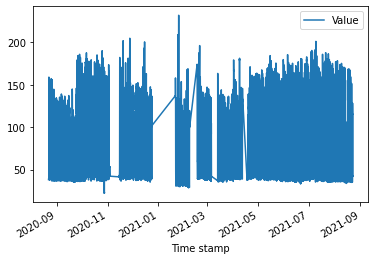

In [88]:
meter_sum.plot(x="Time stamp", y="Value")

In [89]:
meter_sum.to_csv("./library.csv")